# DAT200 CA4 2022

Kaggle username: JisooPark

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# data propressessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# modeling
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


### Reading data

In [2]:
tr = pd.read_csv("train.csv", index_col=0)
te = pd.read_csv("test.csv", index_col=0)

tr.head()

,Rooms,Type,Method,Distance,Postcode,Bedrooms,Bathroom,Car,Landsize,YearBuilt,Lattitude,Longtitude,Regionname,Propertycount,Price class
0,4,h,S,6.4,3011.0,3.0,1.0,2.0,411.0,NaN,-37.79690,144.90490,Western Metropolitan,7570.0,1
1,4,h,S,14.6,3189.0,4.0,1.0,2.0,638.0,1972.0,-37.93780,145.05700,Southern Metropolitan,2555.0,1
2,5,h,PI,12.4,3107.0,5.0,4.0,2.0,968.0,1970.0,-37.77083,145.11516,Eastern Metropolitan,5420.0,1
3,3,h,SP,5.2,3056.0,3.0,1.0,2.0,264.0,NaN,-37.76110,144.96440,Northern Metropolitan,11918.0,0
4,3,h,S,8.8,3072.0,3.0,1.0,2.0,610.0,NaN,-37.75100,145.01970,Northern Metropolitan,14577.0,0


**Data description**
- Rooms: Number of rooms
- Method: 
    - S - property sold
    - SP - property sold prior
    - SA - sold after auction
    - VB - vendor bid
    - PI - property passed in
- Type: 
    - h - house,cottage,villa, semi,terrace
    - u - unit, duplex
    - t - townhouse
- Distance: Distance from CBD (Central Business District)
- Postcode: Zip code
- Regionname: Region of the city
- Propertycount: Number of properties that exist in the area of the property.
- Bedroom : Number of bedrooms
- Bathroom: Number of Bathrooms
- Car: Number of parking spots
- Landsize: Land Size
- YearBuilt: Year the property was built
- Lattitude/Longditude: Coordinates of the property
- Price class: 0, 1 or 2. Price class the property got sold for

### Data exploration and visualisation

In [3]:
# count of the Y variable
print(tr['Price class'].value_counts() )
print("="*40)
print("ratio of y: \n", tr['Price class'].value_counts()/len(tr))

0    7189
1    3643
2     711
Name: Price class, dtype: int64
ratio of y: 
 0    0.622802
1    0.315603
2    0.061596
Name: Price class, dtype: float64


In [4]:
# check whether data contains null
print("Training data set size: ", tr.shape)
print("=" * 40)
# tr.info() # brief info of the raw data
# tr.isnull().sum().sort_values(ascending=False) # number of missing variables of each column
round(tr.isnull().sum(axis=0).sort_values(ascending=False)/len(tr) * 100, 2) # percentage of missing variables of each column

Training data set size:  (11543, 15)


YearBuilt        39.61
Car               0.46
Bathroom          0.40
Propertycount     0.35
Landsize          0.29
Rooms             0.00
Type              0.00
Method            0.00
Distance          0.00
Postcode          0.00
Bedrooms          0.00
Lattitude         0.00
Longtitude        0.00
Regionname        0.00
Price class       0.00
dtype: float64

<AxesSubplot:>

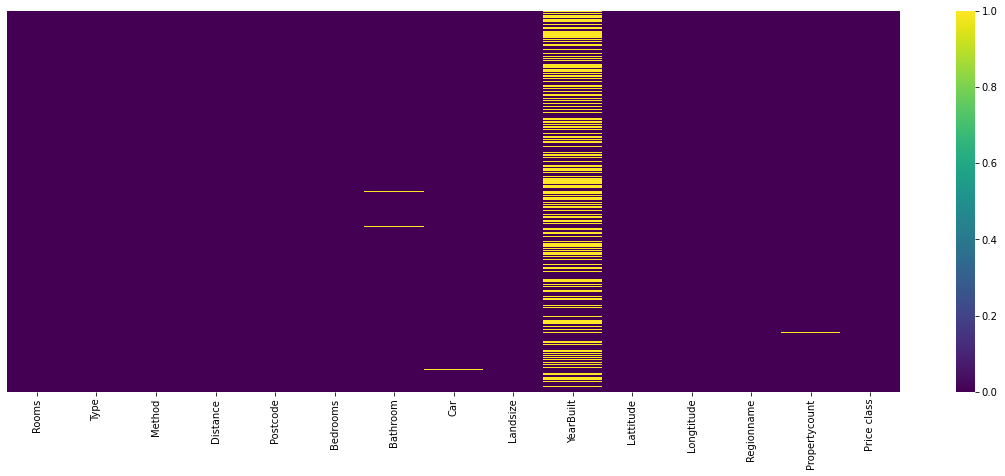

In [5]:
fig, ax = plt.subplots(figsize=(20, 7))
sns.heatmap(tr.isnull(), yticklabels=False,cmap="viridis")

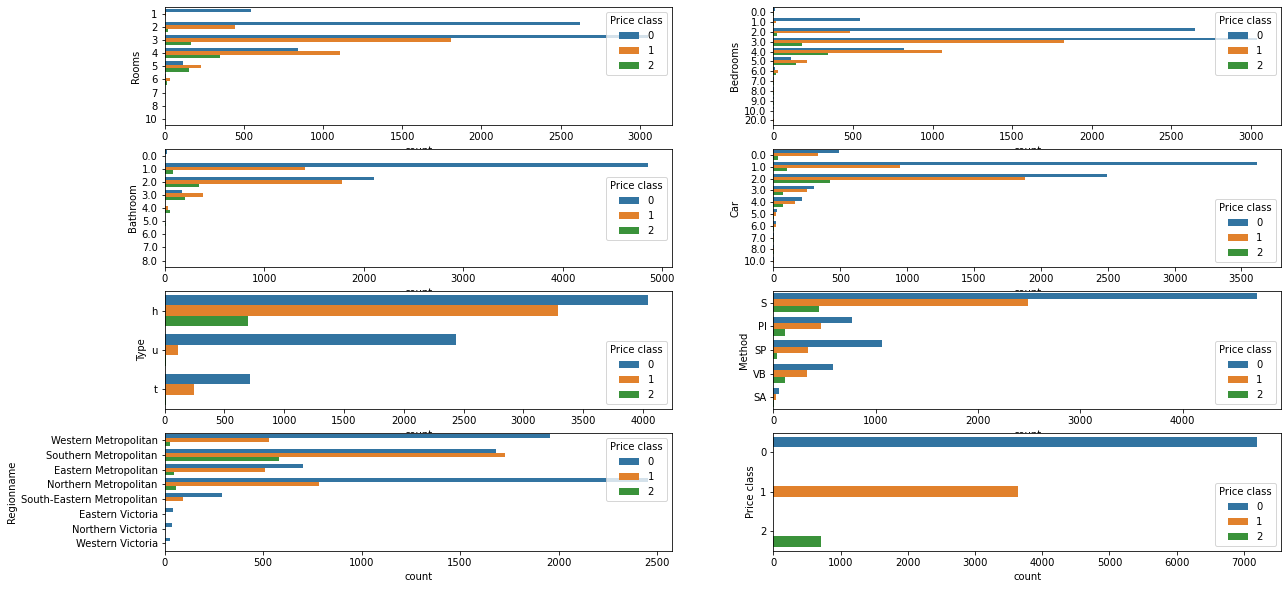

In [6]:
# Original data distribution by columns
fig, axes = plt.subplots(nrows = 4, ncols = 2, figsize = (20, 10))
tr_ctg = tr[['Rooms', 'Bedrooms', 'Bathroom','Car', 'Type', 'Method', 'Regionname', 'Price class']]
for i, col_name in enumerate(tr_ctg):
    row = i // 2
    col = i % 2
    if row in range(0, 4):
        sns.countplot(data = tr_ctg, y = col_name, hue = 'Price class', ax = axes[row][col])     

plt.show()

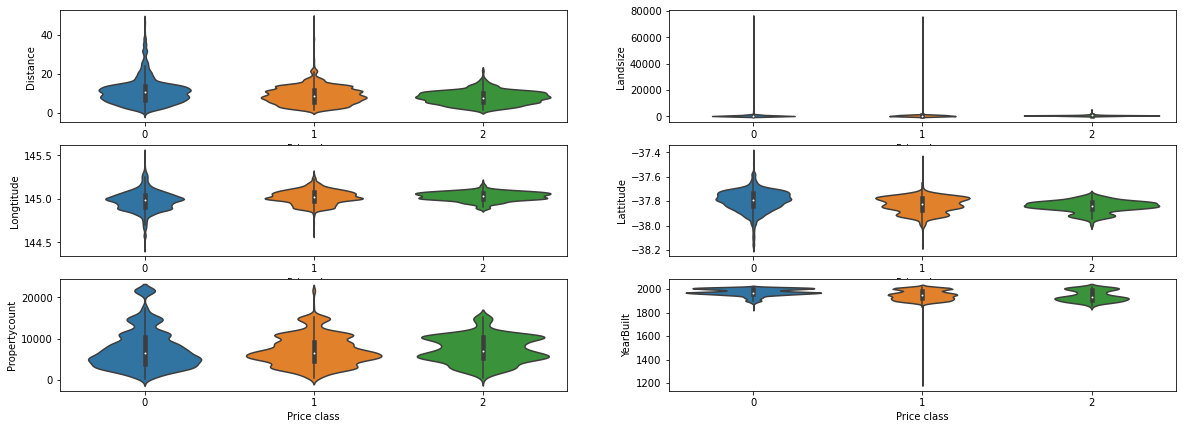

In [7]:
# Original data distribution by columns
fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (20, 7))
tr_num = tr[['Distance', 'Landsize',  'Longtitude','Lattitude', 'Propertycount','YearBuilt', 'Price class']]
for i, col_name in enumerate(tr_num):
    row = i // 2
    col = i % 2
    if row in range(0, 3):
        sns.violinplot(data = tr_num, x = 'Price class', y = col_name, ax = axes[row][col])
plt.show()

<Figure size 1440x504 with 0 Axes>

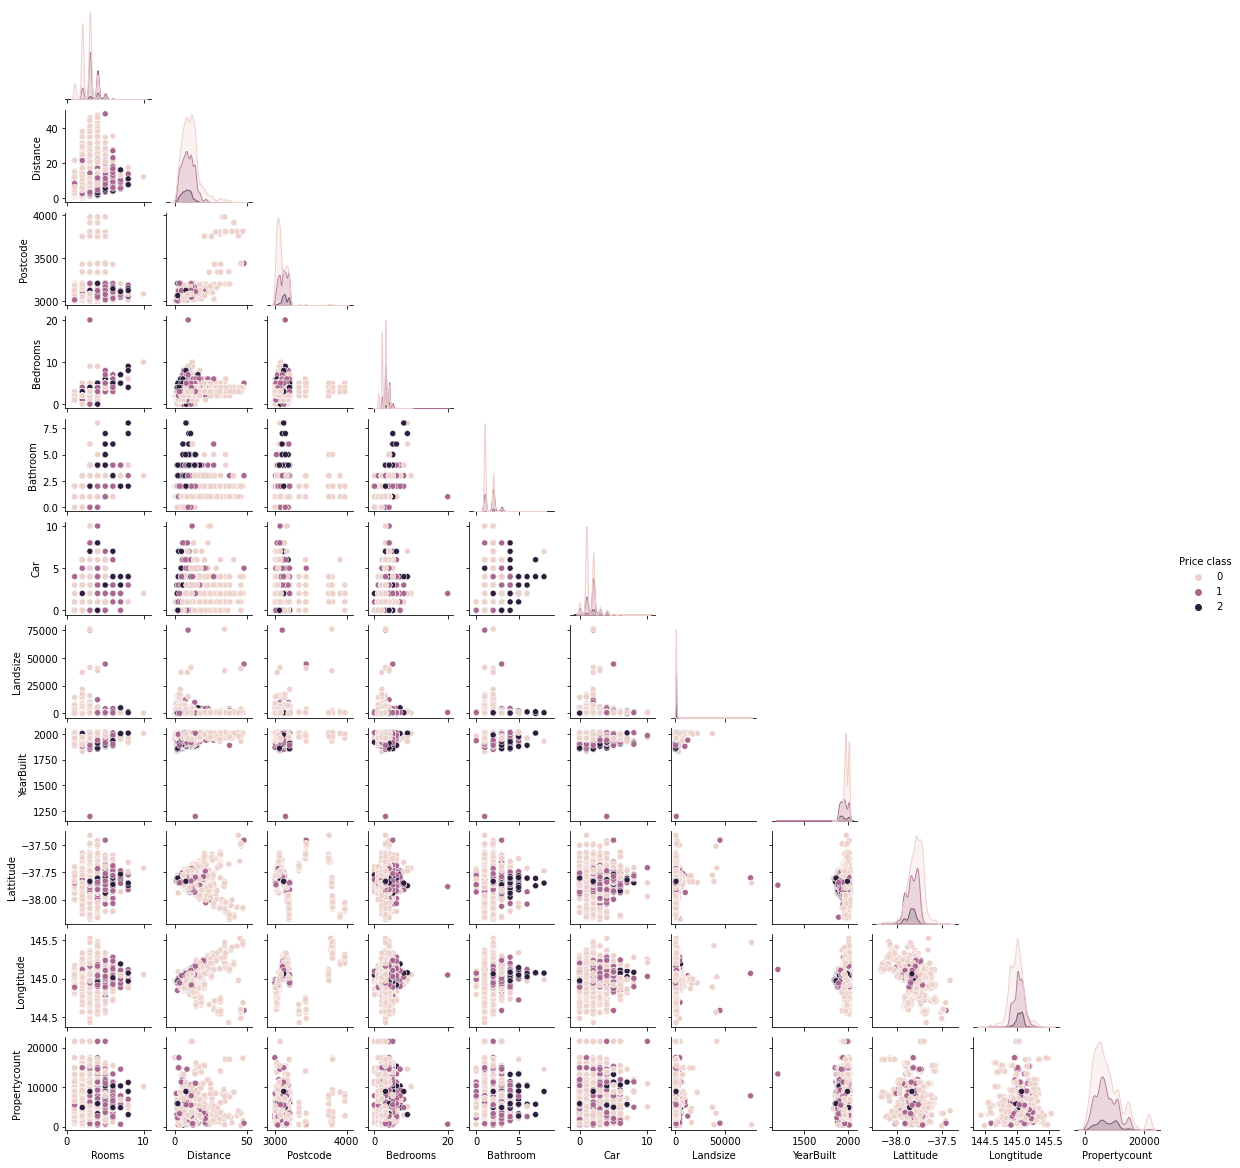

In [8]:
# pariplot
plt.figure(figsize = (20, 7))
sns.pairplot(data= tr,
             hue = 'Price class',
             height = 1.5, corner = True)
plt.show()

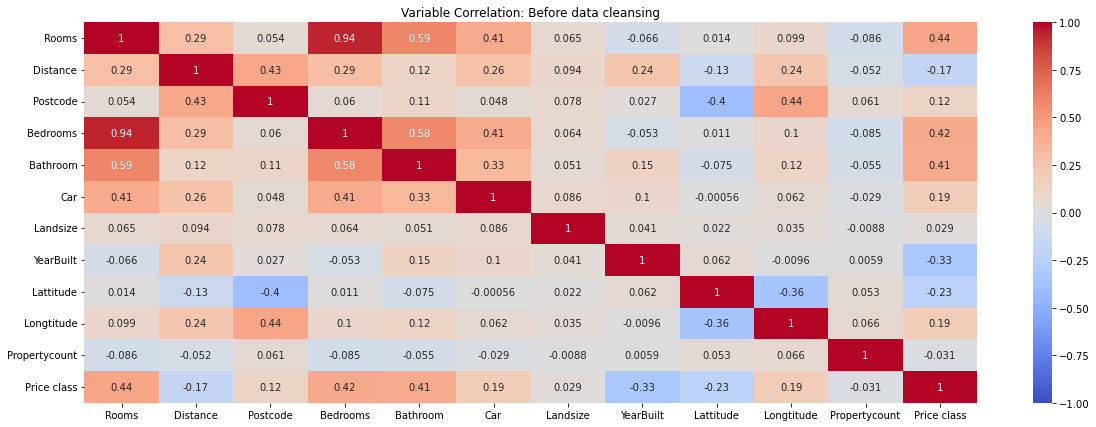

In [9]:
plt.figure(figsize = (20, 7))
sns.heatmap(tr.corr(), annot = True, vmax = 1, vmin = -1, cmap = 'coolwarm')
plt.title("Variable Correlation: Before data cleansing")
plt.show()

<AxesSubplot:xlabel='Lattitude', ylabel='Longtitude'>

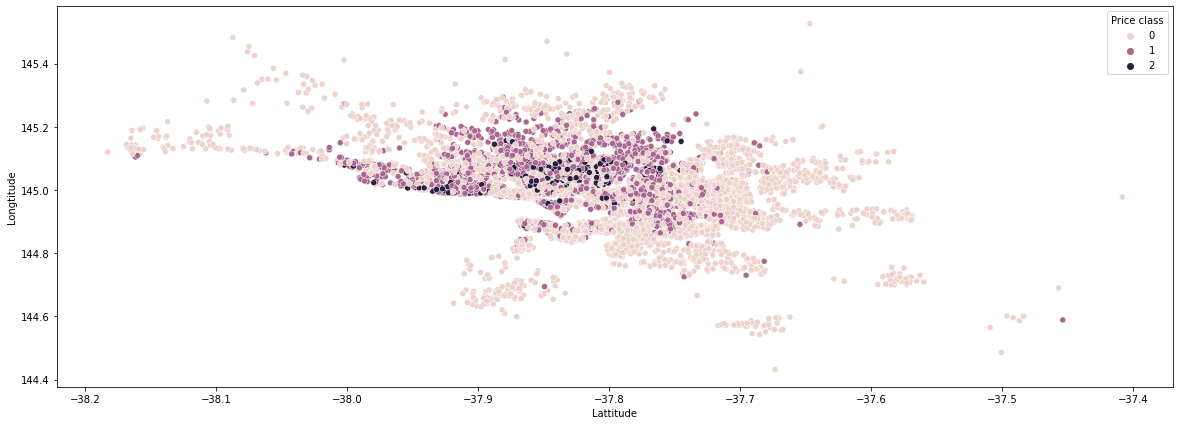

In [10]:
# postcode, longtitude, Latitude, Regionname
tr_geo = tr[['Postcode', 'Lattitude', 'Longtitude', 'Regionname', 'Price class']]
plt.figure(figsize=(20, 7))
sns.scatterplot(data = tr_geo, x="Lattitude", y="Longtitude", hue="Price class")

<AxesSubplot:xlabel='Lattitude', ylabel='Longtitude'>

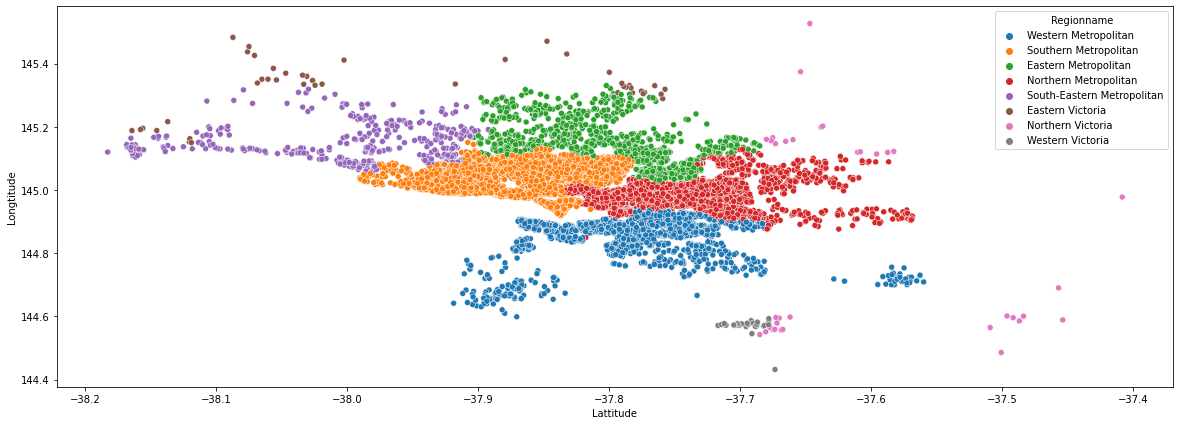

In [11]:
plt.figure(figsize=(20, 7))
sns.scatterplot(data = tr_geo, x="Lattitude", y="Longtitude", hue="Regionname")

The target variable(`Price class`) is imbalanced so it needs to use a sampling technic in order to balance. `Type`, `Method`, and `Regionname` are categorical variables so we need to transform them into a numeric variable using one-hot-coding. `Lattitude`, and `Longitude` variables are utilized in spatial analysis. We can see there is a high `Price class` in Southern Metropolitan area.
`Rooms` and `Bedrooms` are strongly correlated, and `Bathroom` also has a high correlation. In this analysis, we could consider choosing `Rooms` rather than using all three variables due to the high correlation, and excluding `Postcode`, `Regionname` in order to reduce the number of overlapped variables. 

### Data cleaning

The following variables contain missing values; `Car`, `Landsize`, `YearBuilt`, and `Propertycount`. In the case of `YearBuilt`, 39.6%(= 4572/11543) of data are missing, so it needs to impute the values. One of the ways to dealing is by using its mean or median. Here, we would like to apply the median to missing values and one-hot-encoding to categorical variables.

In [12]:
# Drop Postcode
tr2 = tr.drop(['Postcode', 'Bedrooms', 'Bathroom'], axis = 1)

In [13]:
num_cols = [col for col in tr2.columns if tr2[col].dtype in ['float64','int64']]
ctg_cols = [col for col in tr2.columns if tr2[col].dtype not in ['float64','int64']]
print("Categorical variables: ", ctg_cols, "\nNumerical variables: ", num_cols)

Categorical variables:  ['Type', 'Method', 'Regionname'] 
Numerical variables:  ['Rooms', 'Distance', 'Car', 'Landsize', 'YearBuilt', 'Lattitude', 'Longtitude', 'Propertycount', 'Price class']


In [14]:
## eliminate outliers
# import scipy.stats as stats
# #find absolute value of z-score for each observation
# z = np.abs(stats.zscore(tr2[num_cols]))
# data_clean = tr2[(z<3).all(axis=1)]
# data_clean.describe()

def remove_outliers(dataframe, remove_col):
    dff = dataframe
    for k in remove_col:
        level_1q = dff[k].quantile(0.25)
        level_3q = dff[k].quantile(0.75)
        IQR = level_3q - level_1q
        rev_range = 3  
        dff = dff[(dff[k] <= level_3q + (rev_range * IQR)) & (dff[k] >= level_1q - (rev_range * IQR))]
        dff = dff.reset_index(drop=True)
    return dff

data_clean = remove_outliers(tr2, tr2[num_cols])

print("Before: ", tr2.shape, ", After: ", data_clean.shape)
data_clean.describe()


Before:  (11543, 12) , After:  (6674, 12)


,Rooms,Distance,Car,Landsize,YearBuilt,Lattitude,Longtitude,Propertycount,Price class
count,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000
mean,2.936620,9.887504,1.571621,407.184297,1964.462841,-37.806954,144.992725,7423.752173,0.436020
std,0.958465,5.285562,0.864425,318.136898,36.178088,0.075119,0.100609,4308.313214,0.616616
min,1.000000,0.000000,0.000000,0.000000,1850.000000,-38.079600,144.551060,389.000000,0.000000
25%,2.000000,6.100000,1.000000,157.000000,1940.000000,-37.856760,144.929000,4442.000000,0.000000
50%,3.000000,9.200000,2.000000,372.000000,1970.000000,-37.802645,144.998900,6567.000000,0.000000
75%,4.000000,12.800000,2.000000,626.750000,1998.000000,-37.756905,145.055700,10175.000000,1.000000
max,6.000000,33.300000,5.000000,2064.000000,2018.000000,-37.565330,145.373890,21650.000000,2.000000


### Data exploration after cleaning

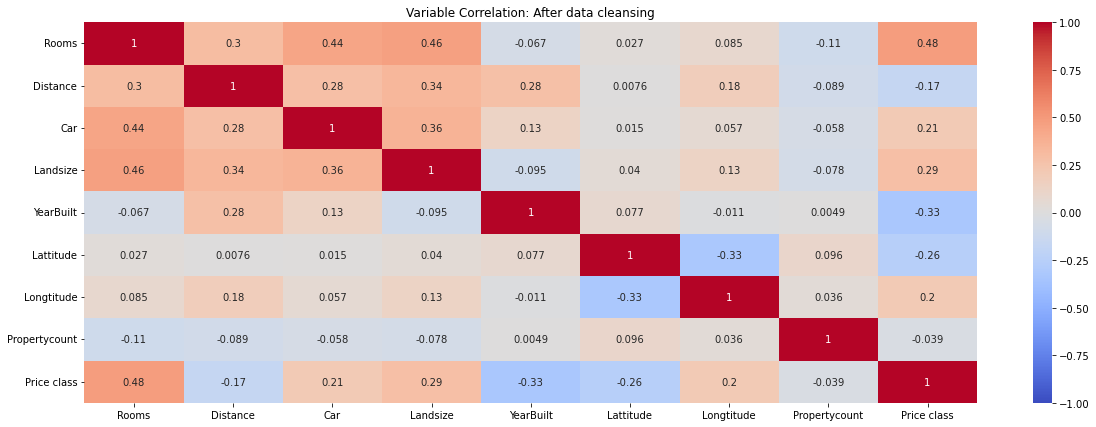

In [15]:
plt.figure(figsize = (20, 7))
sns.heatmap(data_clean.corr(), annot = True, vmax = 1, vmin = -1, cmap = 'coolwarm')
plt.title("Variable Correlation: After data cleansing")
plt.show()

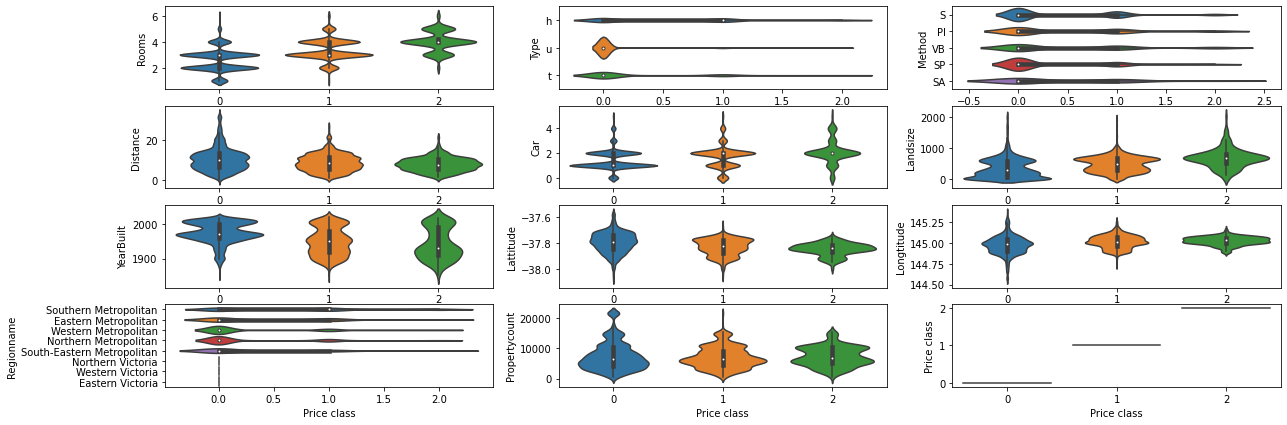

In [16]:
# Original data distribution by columns
fig, axes = plt.subplots(nrows = 4, ncols = 3, figsize = (20, 7))
for i, col_name in enumerate(data_clean):
    row = i // 3
    col = i % 3
    if row in range(0, 4):
        sns.violinplot(data = data_clean, x = 'Price class', y = col_name, ax = axes[row][col])
plt.show()

### Data preprocessing

In [17]:
y = data_clean["Price class"]

X = data_clean.drop(["Price class"], axis = 1)
X = pd.get_dummies(X, columns=ctg_cols)

print(X.shape)
print(y.shape)

(6674, 24)
(6674,)


In [18]:
le = LabelEncoder()
y = le.fit_transform(y)
le.classes_
unique, counts = np.unique(y, return_counts=True)
print(dict(zip(unique, counts)))

{0: 4212, 1: 2014, 2: 448}


In [19]:
# Equal applying to test data
te2 = te.drop(['Postcode', 'Bedrooms', 'Bathroom'], axis =1)
te2 = pd.get_dummies(te2,columns=ctg_cols)

print(te2.shape)

(1230, 24)


#### Train test split

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.30,
                                                    stratify=y, random_state=1)
print("X_train: ", X_train.shape,", X_test: ", X_test.shape)
print("y_train: \n", np.bincount(y_train))
print("y_test: \n", np.bincount(y_test))

X_train:  (4671, 24) , X_test:  (2003, 24)
y_train: 
 [2948 1410  313]
y_test: 
 [1264  604  135]


#### Scaling

In [21]:
sc = StandardScaler()
sc.fit(X_train)

# Transform (standardise) both X_train and X_test with mean and STD from
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [22]:
from imblearn.over_sampling import SMOTE
# oversampling
SMOTE = SMOTE()

X_train_std_smote, y_train_smote = SMOTE.fit_resample(X_train_std, y_train)
print("Before oversampling: \n", np.bincount(y_train))
print("After oversampling: \n", np.bincount(y_train_smote))

under = RandomUnderSampler()
X_train_std_under, y_train_under = under.fit_resample(X_train_std, y_train)
print("Before undersampling: \n", np.bincount(y_train))
print("After undersampling: \n", np.bincount(y_train_under))

Before oversampling: 
 [2948 1410  313]
After oversampling: 
 [2948 2948 2948]
Before undersampling: 
 [2948 1410  313]
After undersampling: 
 [313 313 313]


### Modelling

#### Data pipeline with kernel

In [23]:
def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

In [24]:
# Define the pipeline (scaling and classification) 
pipe_svc = make_pipeline(StandardScaler(), SVC(random_state=1))

# Define ranges of parameter values:
param_range  = [0.01, 0.1, 1.0, 10.0, 100.0] # For regularization parameter C.
param_range2 = [0.01, 0.1, 1.0, 10.0, 100.0] # For scaling parameter gamma og rbf-kernel.

param_grid   = [{'svc__C': param_range, 
                 'svc__gamma': param_range2, 
                 'svc__kernel': ['rbf']}]

svcgs = GridSearchCV(estimator=pipe_svc, 
                  param_grid=param_grid, 
                  scoring='accuracy',
                  cv=10,
                  n_jobs=-1)

svcgs = svcgs.fit(X_train_std_under, y_train_under)
print("Best Score: ", svcgs.best_score_)
print("Best Parameter:", svcgs.best_params_)

Best Score:  0.7870052619537864
Best Parameter: {'svc__C': 100.0, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}


In [25]:
sc.fit(te2)
te3 = sc.transform(te2)
svcgs_pred = svcgs.predict(te3)
np.bincount(svcgs_pred)

svcgs_res = pd.DataFrame(svcgs_pred, columns=['Price class'])
svcgs_res = svcgs_res.rename_axis('index').reset_index()
svcgs_res['Price class'].value_counts()

0    694
1    428
2    108
Name: Price class, dtype: int64

In [26]:
# Data Export
svcgs_res.to_csv('svcgs_res.csv',
                  float_format = '%.2f',
                 index=False)

#### Data pipeline with regularization

In [27]:
params = {
    'n_estimators':[50, 100, 150, 200],
    'max_depth' : [5, 10, 15, 20], 
    'min_samples_leaf' : [5, 12, 19],
    'min_samples_split' : [5, 7, 9, 11]
}

rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf , param_grid=params , cv=10, n_jobs=-1 )
grid_cv.fit(X_train_std_under , y_train_under)

print("Best Score: ", grid_cv.best_score_)
print("Best Parameter:", grid_cv.best_params_)

Best Score:  0.7858956760466713
Best Parameter: {'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 11, 'n_estimators': 200}


In [28]:
sc.fit(te2)

# Transform (standardise) both X_train and X_test with mean and STD from

te3 = sc.transform(te2)
pred = grid_cv.predict(te3)
np.bincount(pred)

output = pd.DataFrame(pred, columns=['Price class'])
output = output.rename_axis('index').reset_index()
output['Price class'].value_counts()

0    692
1    439
2     99
Name: Price class, dtype: int64

In [29]:
# Data Export
output.to_csv('rf_pred.csv',
                  float_format = '%.2f',
                 index=False)

#### Other models used for Kaggle submission

### Final Evaluation and confusion matrix

In [30]:
print_score(grid_cv, X_train_std_under, y_train_under, X_test_std, y_test, train=True)
print_score(grid_cv, X_train_std_under, y_train_under, X_test_std, y_test, train=False)

Train Result:
Accuracy Score: 86.58%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1           2  accuracy   macro avg  \
precision    0.898026    0.792683    0.912052  0.865815    0.867587   
recall       0.872204    0.830671    0.894569  0.865815    0.865815   
f1-score     0.884927    0.811232    0.903226  0.865815    0.866462   
support    313.000000  313.000000  313.000000  0.865815  939.000000   

           weighted avg  
precision      0.867587  
recall         0.865815  
f1-score       0.866462  
support      939.000000  
_______________________________________________
Confusion Matrix: 
 [[273  40   0]
 [ 26 260  27]
 [  5  28 280]]

Test Result:
Accuracy Score: 79.58%
_______________________________________________
CLASSIFICATION REPORT:
                     0           1           2  accuracy    macro avg  \
precision     0.938543    0.655608    0.476190  0.795806     0.690114   
recall        0.845728    0.687086    

### Kaggle submission

In [31]:
# randomforest
print("Best Parameter:", grid_cv.best_params_)

Best Parameter: {'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 11, 'n_estimators': 200}


Using the undersampling with a random forest classifier, we can get a benchmark classification( F1 macro score) over 0.75540. In the testing data set, we can get a slightly lower benchmark classification because the undersampling technic causes the overfitting problem. To solve this task, we may need to do further feature selection and feature engineering.

#### ROC Curve for binary classificaion problem

two-class problem distinguishing between "Price class"=1 and "Price class"=2 and produce a single ROC curve based on 5-fold cross-validation.

In [32]:
tmp = tr[tr['Price class'] != 0]
# tmp['Price class'].values_count()
tmp['Price class'].value_counts()
tmp = tmp.dropna()

In [33]:
tmp.shape

(2497, 15)

In [34]:
tmpy = tmp["Price class"]

tmpX = tmp.drop(["Price class"], axis = 1)
tmpX = pd.get_dummies(tmpX, columns=ctg_cols)

le = LabelEncoder()
tmpy = le.fit_transform(tmpy)
le.classes_

array([1, 2], dtype=int64)

In [35]:
x_train, x_test, tmpy_train, tmpy_test = train_test_split(tmpX, tmpy, 
                                                    train_size=0.7, random_state=0)

In [36]:
sc = StandardScaler()
sc.fit(x_train)

# Transform (standardise) both X_train and X_test with mean and STD from
x_train_std = sc.transform(x_train)
x_test_std = sc.transform(x_test)

In [37]:
# Train a single random forest classifier
rfc = RandomForestClassifier(random_state=1)
rfc.fit(x_train_std, tmpy_train)
rfc_y_pred = rfc.predict(x_test_std)

In [38]:
y_test.shape, rfc_y_pred.shape

((2003,), (750,))

In [39]:
rfc_cv_score = cross_val_score(rfc, tmpX, tmpy, cv=5, scoring='accuracy')
print("=== Confusion Matrix ===")
print(confusion_matrix(tmpy_test, rfc_y_pred))
print('\n')
print("=== Classification Report ===")
print(classification_report(tmpy_test, rfc_y_pred))
print('\n')
print("=== All AUC Scores ===")
print(rfc_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_cv_score.mean())

=== Confusion Matrix ===
[[594  19]
 [ 65  72]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.90      0.97      0.93       613
           1       0.79      0.53      0.63       137

    accuracy                           0.89       750
   macro avg       0.85      0.75      0.78       750
weighted avg       0.88      0.89      0.88       750



=== All AUC Scores ===
[0.878      0.878      0.89378758 0.89178357 0.87975952]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.8842661322645291


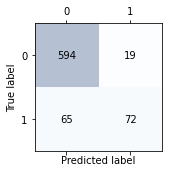

In [40]:
confmat = confusion_matrix(y_true=tmpy_test, y_pred=rfc_y_pred)

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.show()

C:\Users\catha\miniconda3\envs\dat200\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\catha\miniconda3\envs\dat200\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

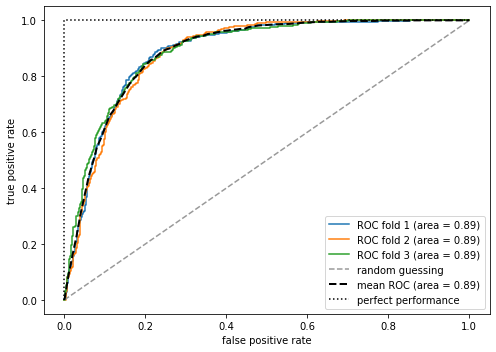

In [45]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc

# Set up pipeline with scale, decomposer and classifyer
pipe_lr = make_pipeline(StandardScaler(),
                        PCA(),
                        LogisticRegression(penalty='l2', 
                                           random_state=1, 
                                           C=1000.0,
                                           solver='lbfgs'))

# Cross-validation specification
cv = list(StratifiedKFold(n_splits=3).split(X_train, y_train))

fig = plt.figure(figsize=(7, 5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

# Loop through folds of CV
for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train.values[train],
                         y_train[train]).predict_proba(X_train.values[test]) # Predict probability of classes

    # False Positive and True Positive Rates (thresholds for the decision function)
    fpr, tpr, thresholds = roc_curve(y_train[test],
                                     probas[:, 1],
                                     pos_label=1)
    # Add to mean True Predictive Rate in a smoothed variant (interpolated)
    mean_tpr += np.interp(mean_fpr, fpr, tpr)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,
             tpr,
             label='ROC fold %d (area = %0.2f)'
                   % (i+1, roc_auc))

plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='random guessing')

# Average True Positive Rate
mean_tpr /= len(cv)
mean_tpr[0] = 0.0
mean_tpr[-1] = 1.0
# Average AUC
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='mean ROC (area = %0.2f)' % mean_auc, lw=2)
plt.plot([0, 0, 1],
         [0, 1, 1],
         linestyle=':',
         color='black',
         label='perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

In [43]:

def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()

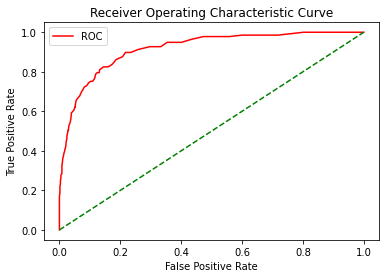

In [44]:
prob = rfc.predict_proba(x_test_std)
prob = prob[:, 1]
fper, tper, thresholds = roc_curve(tmpy_test, prob)
plot_roc_curve(fper, tper)